# Circuit for Shor’s algorithm using 2n+3 qubits
In this notebook, Shor's algorithm is efficiently implemented using the method described in [arXiv:quant-ph/0205095](https://arxiv.org/pdf/quant-ph/0205095.pdf) by Stéphane Beauregard. 

### Imports

In [69]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, SwapGate
from qiskit.extensions import UnitaryGate
from random import randrange
from sympy import Matrix
import numpy as np

### Classical parts

In [2]:
def euclids(a, b):
    """
    Given two integers a and b, compute gcd(a, b) using Euclid's algorithm.
    
    Parameters:
    -----------
    a: int
        First integer for Euclid's algorithm
    b: int
        Second integer for Euclid's algorithm
        
    Returns:
    --------
    b: int
        Returns gcd(a, b) stored on input b
    """
    while True:
        r = a % b
        if not r:
            break
        a = b
        b = r
    return b

In [110]:
def a2jmodN(a, j, N):
    """
    Compute a^{2^j} (mod N) by repeated squaring
    
    Parameters:
    -----------
    a: int
        Value for a
    j: int
        Value for j
    N: int
        Value for N
        
    Returns:
    --------
    a: int
        a^{2^j} (mod N)
    """
    for i in range(j):
        a = np.mod(a**2, N)
    return a

### Quantum part

Set inital state to register

In [4]:
def set_initial(n, val_a):
    """
    Construct gate to set initial state of register with size n to val_a.
    For example n=4 with val_a=5 will apply X gates on qubits 0 and 2. 
    
    Parameters:
    -----------
    n: int
        Size of register we want to initialize
    val_a: int
        Value to which we want to initialize 
        
    Returns:
    --------
    init_gate: Gate
        Constructed gate
        
    """
    if ((2**n) - 1) < val_a:
        raise Exception(f'Cannot initialize {val_a} into given register, there are no sufficient qubits')
        
    reg_a = QuantumRegister(n)
    gate  = QuantumCircuit(reg_a)
    
    bin_a = "{0:b}".format(val_a).zfill(n)
    for idx, i in enumerate(bin_a[::-1]):
        if i == '1': gate.x(idx)

    init_gate = gate.to_gate(label=f'Init {val_a}')
    return init_gate

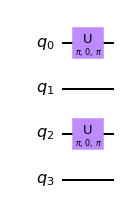

In [5]:
qc = QuantumCircuit(4)

init = set_initial(4, 5)
qc.append(init, [0,1,2,3])
qc = transpile(qc, basis_gates=['u', 'cx'])
qc.draw('mpl')

Adder and subtracter.

In [6]:
def adder(n, val_a, dag=False):
    """
    Construct gate to add val_a into register b in the Fourier basis.
    Register b must contain the number on the Fourier basis already.
    The subtracter gate gives us b - a if b ≥ a or 2^{n+1}−(a−b) if b < a. It is obtained by inversing the adder.
    
    Parameters:
    -----------
    n: QuantumRegister
        Size of register b
    val_a: int
        Value to which register a will be initialized
    dag: Boolean
        If set to true, the dagger of the adder gate (the subtracter) is appended
    
    Returns:
    --------
    adder_gate: Gate
        Constructed gate
    """
    
    bin_a = "{0:b}".format(val_a).zfill(n)
    phase = lambda lam: np.array([[1, 0], [0, np.exp(1j * lam)]])
    identity = np.array([[1, 0], [0, 1]])
    arr_gates = []
    
    for i in range(n):
        qubit_gate = identity
        for j in range(i, n):
            if bin_a[j] == '1':
                qubit_gate = phase(np.pi / (2 ** (j - i))) @ qubit_gate
        arr_gates.append(qubit_gate)

    unitary = arr_gates[0]
    for i in range(1, len(arr_gates)):
        unitary = np.kron(arr_gates[i], unitary)
    
    adder_gate = UnitaryGate(unitary)
    adder_gate.label = f"Add {val_a}"
    if dag == True:
        adder_gate = adder_gate.inverse()
        adder_gate.label = f"Subtract {val_a}"
        
    return adder_gate

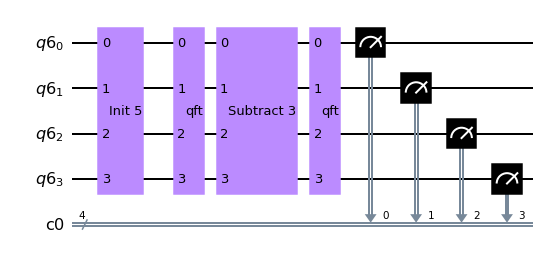

{'0010': 1024}

In [7]:
b = QuantumRegister(4)
c = ClassicalRegister(4)
q = QuantumCircuit(b,c)

add_1 = 5
add_2 = 3

init = set_initial(b.size, add_1)
q.append(init, b[:])

qft = QFT(4)
q.append(qft, b[:])

add = adder(4, add_2, dag=True)
q.append(add, b[:])

qft_i = QFT(4, inverse=True)
q.append(qft_i, b[:])

q.measure(b, c)

display(q.draw('mpl'))

backend = Aer.get_backend('qasm_simulator')
q = transpile(q, basis_gates=['cx', 'u'])
result = backend.run(q).result()
counts = result.get_counts()
counts

Modular adder gate

In [8]:
def mod_adder(n, val_a, val_N):
    """
    Construct gate to compute a + b mod N in the Fourier basis. 
    Register b must contain the number on the Fourier basis already, and the answer will be in this register.
    
    Parameters:
    -----------
    n: QuantumRegister
        Size of register b
    val_a: int
        Value to add to register
    val_N: int
        We take mod of a + b respect to this value
        
    Returns:
    --------
    mod_adder_gate: Gate
        Constructed gate
        
    """ 
    
    reg_c = QuantumRegister(2)
    reg_b = QuantumRegister(n)
    aux   = QuantumRegister(1)
    gate  = QuantumCircuit(reg_c, reg_b, aux)
    
    qft     = QFT(n, name="$QFT$").to_gate()
    qft_inv = QFT(n, inverse=True, name="$QFT^\dag$").to_gate()
    
    gate.append(adder(n, val_a).control(2), reg_c[:] + reg_b[:])
    gate.append(adder(n, val_N, dag=True), reg_b[:])
    
    gate.append(qft_inv, reg_b[:])
    gate.cx(reg_b[-1], aux[0])
    gate.append(qft, reg_b[:])
    
    gate.append(adder(n, val_N).control(1), aux[:] + reg_b[:])
    gate.append(adder(n, val_a, dag=True).control(2), reg_c[:] + reg_b[:])
    
    gate.append(qft_inv, reg_b[:])
    gate.x(reg_b[-1])
    gate.cx(reg_b[-1], aux[0])
    gate.x(reg_b[-1])
    gate.append(qft, reg_b[:])
    
    gate.append(adder(n, val_a).control(2), reg_c[:] + reg_b[:])
    mod_adder_gate = gate.to_gate(label=f"Add {val_a} mod {val_N}")
    
    return mod_adder_gate

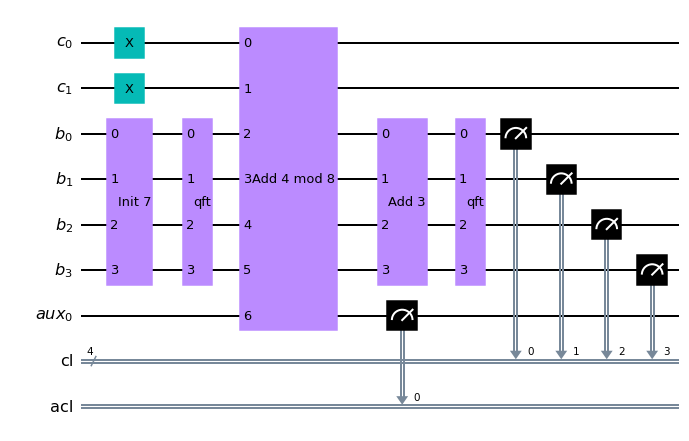

{'0 0110': 1}

In [9]:
c = QuantumRegister(2, name='c')
b = QuantumRegister(4, name='b')
aux = QuantumRegister(1, name='aux')
clas = ClassicalRegister(4, name='cl')
aux_clas = ClassicalRegister(1, name='acl')
qc = QuantumCircuit(c,b,aux,clas,aux_clas)

val_a = 4
val_b = 7 # b < 2 ** (n - 1)
val_N = 8

init = set_initial(b.size, val_b) 
qc.append(init, b[:])

qft = QFT(4)
qc.append(qft, b[:])

qc.x(c)

mod_add = mod_adder(b.size, val_a, val_N)
qc.append(mod_add, c[:] + b[:] + aux[:])

add = adder(b.size, 3)
qc.append(add, b[:])

qft_1 = QFT(4, inverse=True)
qc.append(qft_1, b[:])

qc.measure(b,clas)
qc.measure(aux,aux_clas)

display(qc.draw('mpl'))

backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, basis_gates=['u', 'cx'])
result = backend.run(qc).result()
counts = result.get_counts()
counts

Controlled multiplier gate

In [10]:
def ctrl_mult(n, val_a, val_N, dag=False):
    """
    Construct gate that computes (b + ax) mod N if control qubit is set to 1.
    The gate transforms the value in register b to the Fourier basis within it.
    
    Parameters:
    -----------
    n: QuantumRegister
        Size of registers b and x
    val_a: int
        Value to multiply by x
    val_N: int
        We take mod of (b + ax) mod N respect to this value
    dag: bool
        If set to true, the dagger of the adder gate (the subtracter) is appended
        
    Returns:
    --------
    ctrl_mult_gate: Gate
        Constructed gate
        
    """
    
    reg_c = QuantumRegister(1)
    reg_x = QuantumRegister(n)
    reg_b = QuantumRegister(n)
    aux   = QuantumRegister(1)
    gate  = QuantumCircuit(reg_c, reg_x, reg_b, aux)
    
    qft     = QFT(n, name="$QFT$").to_gate()
    qft_inv = QFT(n, inverse=True, name="$QFT^\dag$").to_gate()
    
    gate.append(qft, reg_b[:])
    
    for i in range(n):
        gate.append(mod_adder(n, (2**i) * val_a, val_N), reg_c[:] + [reg_x[:][i]] + reg_b[:] + aux[:])
        
    gate.append(qft_inv, reg_b[:])
    ctrl_mult_gate = gate.to_gate(label=f"Mult {val_a} mod {val_N}")
    if dag == True:
        ctrl_mult_gate = ctrl_mult_gate.inverse()
        ctrl_mult_gate.label = f"Mult {val_a} mod {val_N} inv"
    
    return ctrl_mult_gate

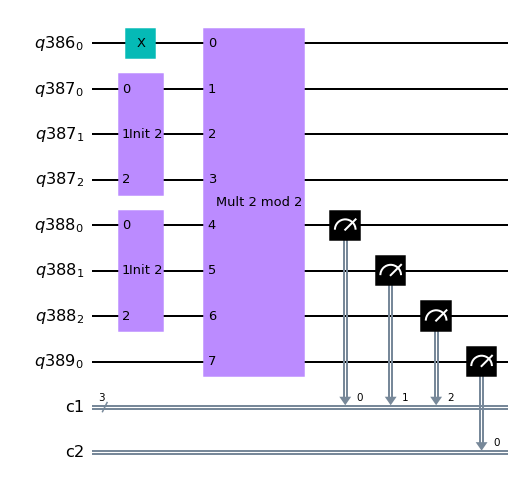

Expected:  2
{'1 010': 1}


In [11]:
vb = 2
va = 2
vx = 2
vN = 4

c = QuantumRegister(1)
x = QuantumRegister(3)
b = QuantumRegister(3)
aux = QuantumRegister(1)

clas_b = ClassicalRegister(3)
clas_aux = ClassicalRegister(1)

qc = QuantumCircuit(c, x, b, aux, clas_b, clas_aux)

qc.x(c)

init_x = set_initial(3, vx)
qc.append(init_x, x[:])

init_b = set_initial(3, vb)
qc.append(init_b, b[:])

cmult = ctrl_mult(3, va, vb, vN)
qc.append(cmult, c[:] + x[:] + b[:] + aux[:])

qc.measure(b, clas_b)
qc.measure(aux, clas_aux)

display(qc.draw('mpl'))

print("Expected: ", ((vb + (va * vx)) % vN))

backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, basis_gates=['u', 'cx'])
result = backend.run(qc).result()
counts = result.get_counts()
print(counts)

Modular inverse: https://www.khanacademy.org/computing/computer-science/cryptography/modarithmetic/a/modular-inverses

In [12]:
def mod_inv(a, N):
    for i in range(N):
        if (a * i) % N == 1: return i
    raise Exception(f"Modular inverse of {a} mod {N} doesn't exist")

In [13]:
def u_a(n, val_a, val_N):
    reg_c = QuantumRegister(1)
    reg_x = QuantumRegister(n)
    reg_y = QuantumRegister(n)
    aux   = QuantumRegister(1)
    
    gate  = QuantumCircuit(reg_c, reg_x, reg_y, aux)
    
    gate.append(ctrl_mult(n, val_a, val_N), reg_c[:] + reg_x[:] + reg_y[:] + aux[:])
    
    temp_qc = QuantumCircuit(2*n)
    temp_qc.swap([i for i in range(n)], [i for i in range(n, 2*n)])
    cswap = temp_qc.to_gate(label='CSWAP').control(1)
    gate.append(cswap, reg_c[:] + reg_x[:] + reg_y[:])
    
    gate.append(ctrl_mult(n, mod_inv(val_a, val_N), val_N, dag=True), reg_c[:] + reg_x[:] + reg_y[:] + aux[:])
    u_a_gate = gate.to_gate(label=f"$U_{val_a}$")
    
    return u_a_gate         

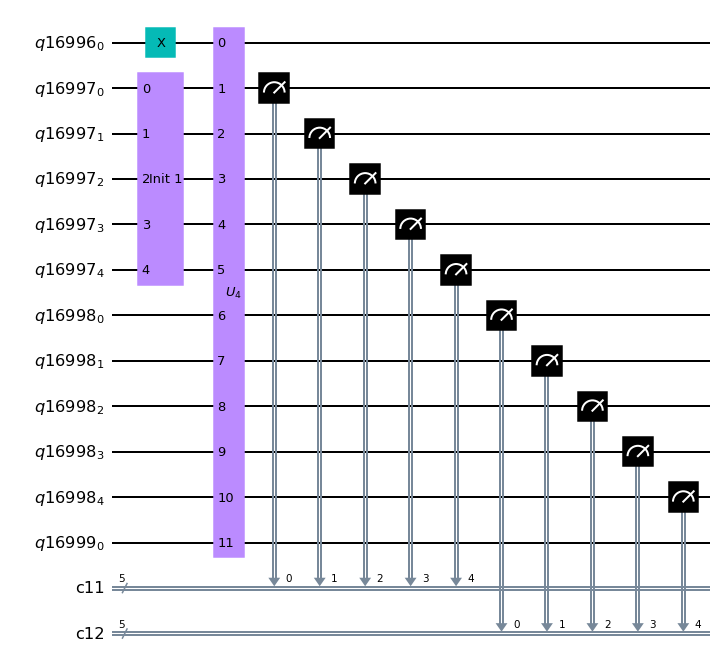

Expected:  4
{'00000 00100': 1}


In [45]:
val_a = 4
val_n = 7
val_x = 1

c = QuantumRegister(1)
x = QuantumRegister(5)
y = QuantumRegister(5)
aux = QuantumRegister(1)
clas_0 = ClassicalRegister(5)
clas_1 = ClassicalRegister(5)
qc = QuantumCircuit(c, x, y, aux, clas_0, clas_1)

qc.x(c)

init_x = set_initial(5, val_x)
qc.append(init_x, x[:])

u = u_a(5, val_a, val_n)
qc.append(u, c[:] + x[:] + y[:] + aux[:])

qc.measure(x, clas_0)
qc.measure(y, clas_1)

display(qc.draw('mpl'))

print("Expected: ", (val_a * val_x) % val_n)

backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, basis_gates=['u', 'cx'])
result = backend.run(qc).result()
counts = result.get_counts()
print(counts)

### Circuit to factorize 15

In [75]:
n = len("{0:b}".format(15))
a = 2
N = 15

In [99]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

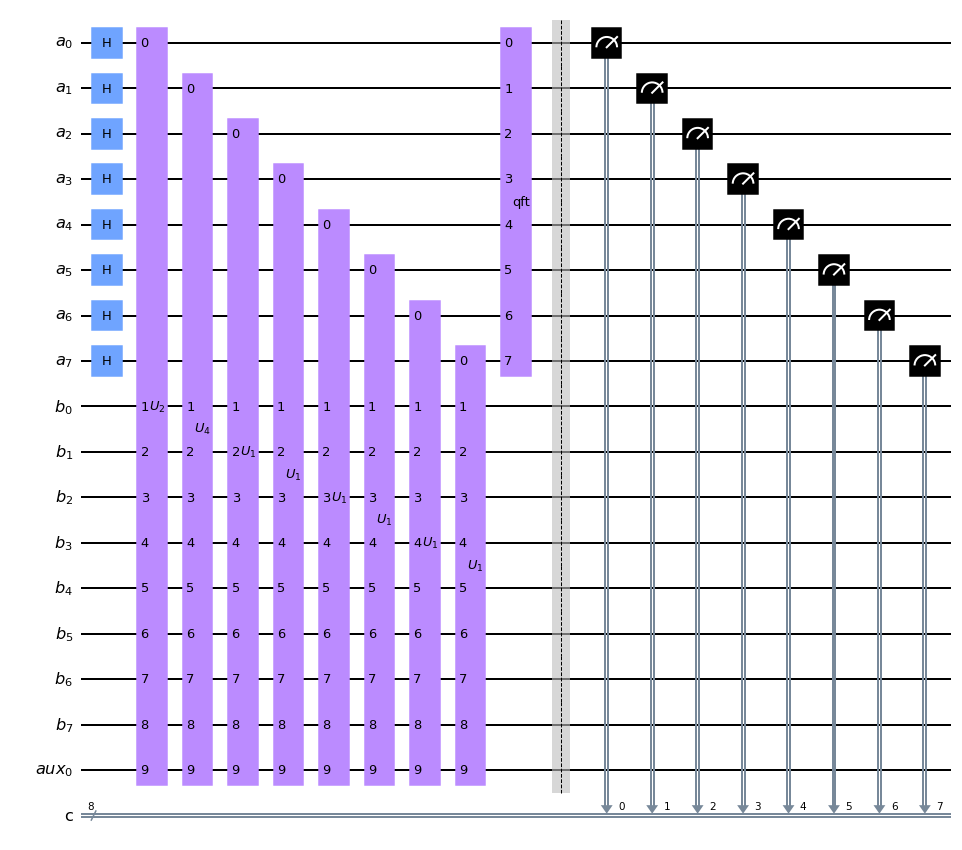

In [109]:
reg_a = QuantumRegister(2 * n, name='a')
reg_b = QuantumRegister(2 * n, name='b')
aux   = QuantumRegister(1, name='aux')
clas  = ClassicalRegister(2 * n, name='c')
qc    = QuantumCircuit(reg_a, reg_b, aux, clas)

qc.h(reg_a)

qc.append(u_a(n, a2jmodN(a, 0, N), N), [reg_a[:][0]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 1, N), N), [reg_a[:][1]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 2, N), N), [reg_a[:][2]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 3, N), N), [reg_a[:][3]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 4, N), N), [reg_a[:][4]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 5, N), N), [reg_a[:][5]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 6, N), N), [reg_a[:][6]] + reg_b[:] + aux[:])
qc.append(u_a(n, a2jmodN(a, 7, N), N), [reg_a[:][7]] + reg_b[:] + aux[:])

qc.append(QFT(2 * n, inverse=True), reg_a[:])

qc.barrier()

qc.measure(reg_a, clas)

qc.draw('mpl')

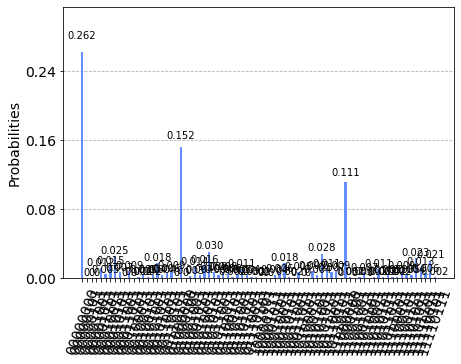

In [111]:
aer_sim = Aer.get_backend('aer_simulator')
qc = transpile(qc, aer_sim)
results = aer_sim.run(qc).result()
counts = results.get_counts()
plot_histogram(counts)

In [112]:
filtered_counts = []
for count in counts:
    if counts[count] > 50:
        filtered_counts.append(count)
filtered_counts

['00000000', '01000000', '11000000']

In [113]:
import pandas as pd

rows, measured_phases = [], []
for output in filtered_counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**(2 * n))  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**(2 * n)} = {phase:.2f}"])

# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  11000000(bin) = 192(dec)  192/256 = 0.75


In [116]:
from fractions import Fraction

rows = []
r_guesses = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
    r_guesses.append(frac.denominator)
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.75      3/4            4


In [120]:
r_guesses

[1, 4, 4]

In [119]:
r = 4
guesses = [euclids(a**(r//2)-1, N), euclids(a**(r//2)+1, N)]
print(guesses)

[3, 5]
